### 시계열 데이터를 가지고 학습해봅시다.

아래 라이브러리를 통해 금융 데이터를 쉽게 받을 수 있습니다

https://pydata.github.io/pandas-datareader/stable/index.html

이번에는 모든 데이터를 사용해서 5일간의 Close를 예측하는 모델을 만들어 봅시다

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [21]:
import pandas_datareader.data as web  # 금융 데이터 다운로드 가능한 라이브러리

df = web.DataReader('005930', 'naver', start='2020-01-01')  # naver는 데이터 소스, 종목 코드에 해당하는 종목이 나옴

In [22]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1083 entries, 2020-01-02 to 2024-05-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    1083 non-null   object
 1   High    1083 non-null   object
 2   Low     1083 non-null   object
 3   Close   1083 non-null   object
 4   Volume  1083 non-null   object
dtypes: object(5)
memory usage: 50.8+ KB


In [24]:
# 숫자로 변환
import pandas as pd
df=df.apply(pd.to_numeric)

<Axes: xlabel='Date'>

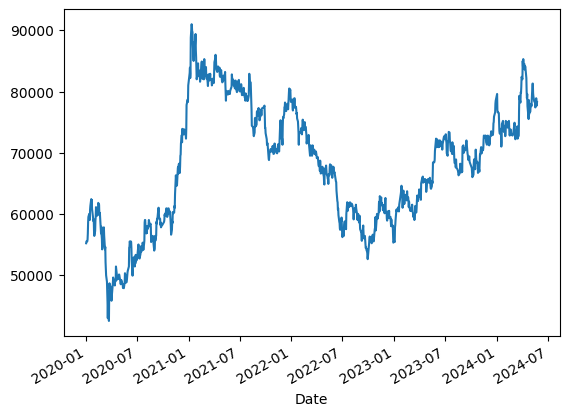

In [25]:
df.Close.plot()

In [26]:
baseline = df.Close.iloc[0]
df.Close = df.Close/baseline - 1

<Axes: xlabel='Date'>

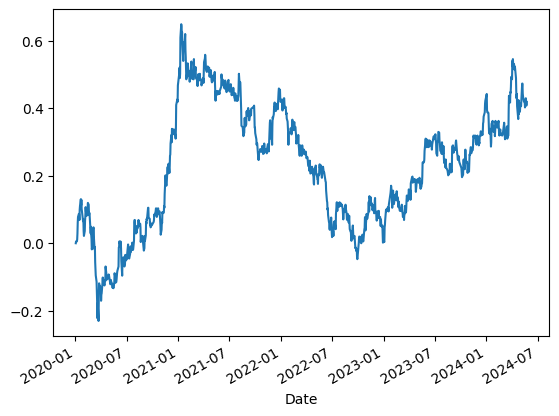

In [27]:
df.Close.plot()

In [28]:
df.Open = df.Open/baseline - 1
df.High = df.High/baseline - 1
df.Low = df.Low/baseline - 1
df.Volume = df.Volume/df.Volume.iloc[0] - 1

In [29]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,0.005435,0.014493,-0.003623,0.000000,0.000000
2020-01-03,0.014493,0.025362,-0.005435,0.005435,0.186946
2020-01-06,-0.005435,0.007246,-0.010870,0.005435,-0.208899
2020-01-07,0.009058,0.021739,0.007246,0.010870,-0.229616
2020-01-08,0.018116,0.039855,0.012681,0.028986,0.808725


In [43]:
def create_inputs(data, seq_len, pred_len):
    xs = []
    ys = []
    for i in range(len(data) - seq_len - pred_len + 1):
        x = data[i:i+seq_len, :]
        y = data[i+seq_len:i+seq_len+pred_len, 3]  # Close 컬럼의 인덱스가 3
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [44]:
inputs, targets = create_inputs(df.values, seq_len=20, pred_len=5)

In [45]:
inputs.shape

(1059, 20, 5)

In [46]:
targets.shape

(1059, 5)

RNN 모델을 만들어 봅시다

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html




* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

* h_n: tensor of shape
(
𝐷
∗
num_layers
,
𝐻
𝑜
𝑢
𝑡
)
(D∗num_layers,H
out
​
 ) for unbatched input or
(
𝐷
∗
num_layers
,
𝑁
,
𝐻
𝑜
𝑢
𝑡
)
(D∗num_layers,N,H
out
​
 ) containing the final hidden state for each element in the batch.

 * batch size
sequence length
2 if bidirectional=True otherwise 1
input_size
hidden_size
​


*  N: 배치크기
 L: 시퀀스 길이
 H_in: Feature 개수 (시계열 기준)


과거 20일 데이터를 가지고, 5일 예측하는 모델을 만들어봅시다. 이때 모든 컬럼을 사용하는 모델을 만들어봅시다

In [33]:
input_size = 5  # feature size
seq_len = 20
hidden_size = 10
num_layers = 2
prediction_len = 5

# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)   #input_size는 feature : Close 1개
        self.linear = nn.Linear(hidden_size* seq_len, prediction_len)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.reshape(out.shape[0], -1) # many to many 전략
        out = self.linear(out)
        return out, hidden

In [34]:
# 모델, 손실 함수, 최적화 함수 초기화
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
%pip install torchinfo

In [36]:
from torchinfo import summary
summary(model, ((1,20, 5),(2,1, 10)))   # Input: Batch, Seq, Feature, Hidden: layer, batch, H_out

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [1, 5]                    --
├─RNN: 1-1                               [1, 20, 10]               390
├─Linear: 1-2                            [1, 5]                    1,005
Total params: 1,395
Trainable params: 1,395
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [47]:
# Train, Test 나누기
train_size = int(len(inputs) * 0.8)
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

In [48]:
print(train_inputs.shape)
print(train_targets.shape)

(847, 20, 5)
(847, 5)


In [49]:
# TensorDataset과 DataLoader 생성 (NumPy 배열을 바로 사용)
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float32),
                              torch.tensor(train_targets, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float32),
                             torch.tensor(test_targets, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 데이터 로더 출력 (형태 확인)
for inputs, targets in train_loader:
    print("Train batch inputs shape:", inputs.shape)  # (batch_size, 20, 1)
    print("Train batch targets shape:", targets.shape) # (batch_size,)
    break

for inputs, targets in test_loader:
    print("Test batch inputs shape:", inputs.shape)  # (batch_size, 20, 1)
    print("Test batch targets shape:", targets.shape) # (batch_size,)
    break

Train batch inputs shape: torch.Size([32, 20, 5])
Train batch targets shape: torch.Size([32, 5])
Test batch inputs shape: torch.Size([1, 20, 5])
Test batch targets shape: torch.Size([1, 5])


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [51]:
model = model.to(device)


In [52]:
# 학습
epochs = 50
hidden = None  #none이면 0으로 초기

for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 배치 크기에 맞는 hidden state 초기화
        if hidden is not None and inputs.size(0) != hidden.size(1):
            hidden = None

        # 모델 초기화
        optimizer.zero_grad()

        # 모델에 입력
        outputs, hidden = model(inputs, hidden)

        # hidden state를 역전파에서 분리 (detach)
        hidden = hidden.detach() if hidden is not None else None

        # 손실 계산
        loss = criterion(outputs, targets)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



Epoch [1/50], Loss: 0.1390
Epoch [1/50], Loss: 0.0891
Epoch [1/50], Loss: 0.0760
Epoch [1/50], Loss: 0.0655
Epoch [1/50], Loss: 0.0589
Epoch [1/50], Loss: 0.0477
Epoch [1/50], Loss: 0.0445
Epoch [1/50], Loss: 0.0341
Epoch [1/50], Loss: 0.0194
Epoch [1/50], Loss: 0.0410
Epoch [1/50], Loss: 0.0351
Epoch [1/50], Loss: 0.0291
Epoch [1/50], Loss: 0.0263
Epoch [1/50], Loss: 0.0307
Epoch [1/50], Loss: 0.0267
Epoch [1/50], Loss: 0.0260
Epoch [1/50], Loss: 0.0263
Epoch [1/50], Loss: 0.0249
Epoch [1/50], Loss: 0.0188
Epoch [1/50], Loss: 0.0289
Epoch [1/50], Loss: 0.0226
Epoch [1/50], Loss: 0.0133
Epoch [1/50], Loss: 0.0136
Epoch [1/50], Loss: 0.0176
Epoch [1/50], Loss: 0.0109
Epoch [1/50], Loss: 0.0168
Epoch [1/50], Loss: 0.0172
Epoch [2/50], Loss: 0.0103
Epoch [2/50], Loss: 0.0122
Epoch [2/50], Loss: 0.0131
Epoch [2/50], Loss: 0.0098
Epoch [2/50], Loss: 0.0090
Epoch [2/50], Loss: 0.0089
Epoch [2/50], Loss: 0.0123
Epoch [2/50], Loss: 0.0111
Epoch [2/50], Loss: 0.0073
Epoch [2/50], Loss: 0.0129
E

In [53]:
predictions = []
actuals = []
with torch.no_grad():
    hidden = None  # 초기 hidden state
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, hidden = model(inputs, hidden)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())


In [54]:
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)



In [72]:
predictions.shape

(212, 5)

In [75]:
actuals.shape

(212, 5)

In [76]:
df_prediction = pd.DataFrame(predictions)
df_actuals = pd.DataFrame(actuals)

In [77]:
df_prediction

,0,1,2,3,4
0,0.330177,0.330560,0.325906,0.326802,0.331249
1,0.327223,0.318665,0.322086,0.322046,0.324550
2,0.321184,0.310725,0.311578,0.311307,0.315435
3,0.302004,0.297639,0.293878,0.295475,0.299885
4,0.282882,0.279910,0.274622,0.273854,0.275882
...,...,...,...,...,...
207,0.462219,0.453799,0.464066,0.461923,0.463260
208,0.461162,0.462505,0.452469,0.452366,0.464270
209,0.454666,0.446670,0.447638,0.451224,0.467741
210,0.435611,0.441453,0.436115,0.433446,0.441023


In [79]:
df_actuals

,0,1,2,3,4
0,0.304348,0.297101,0.266304,0.259058,0.295290
1,0.297101,0.266304,0.259058,0.295290,0.302536
2,0.266304,0.259058,0.295290,0.302536,0.302536
3,0.259058,0.295290,0.302536,0.302536,0.329710
4,0.295290,0.302536,0.302536,0.329710,0.327899
...,...,...,...,...,...
207,0.434783,0.420290,0.418478,0.416667,0.402174
208,0.420290,0.418478,0.416667,0.402174,0.429348
209,0.418478,0.416667,0.402174,0.429348,0.420290
210,0.416667,0.402174,0.429348,0.420290,0.407609


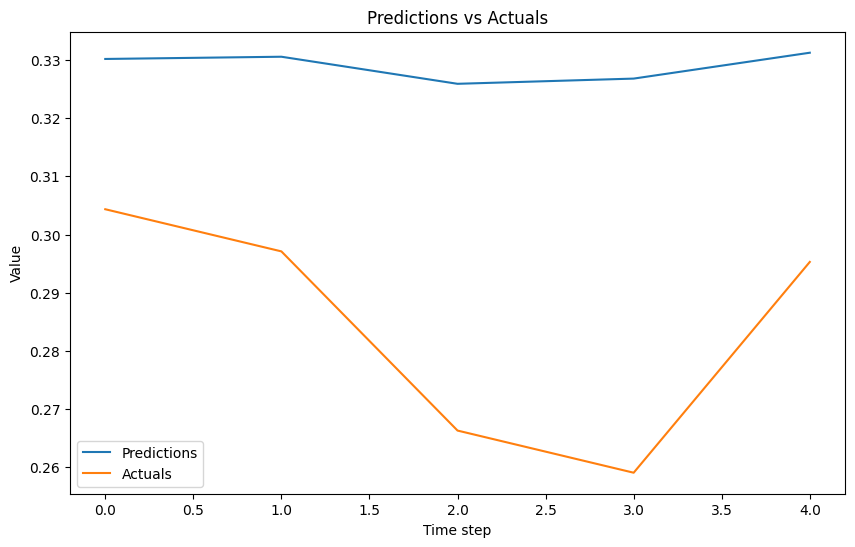

In [59]:
# 예측값과 실제값 시각화 (첫 번째 시퀀스만 플롯)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions[0], label='Predictions')
plt.plot(actuals[0], label='Actuals')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()
